# Aluno: Guilherme Cristiano Goll

In [1]:
import numpy as np
import timeit
import matplotlib.pyplot as plt

In [2]:
ROWS = 6 #Linhas
COLUMNS = 7 #Colunas
BASE = [[0,1], [0,3], [0,5]] #Posições próximas à base, onde serão inseridas as recompensas positivas. A posição central tambem receberá recompensa pois pode receber o objeto 'na contramão'.
BASE_REWARD = 10 #Recompensa dada à base
OBJECT = [[2,2,100], [2,3,'OBJECT'], [2,4,100]] #Posições próximas ao objeto onde serão inseridas as recompensas positivas. A terceira posição trata-se do valor que a célula receberá.
OBJECT_REWARD = 100 #Recompensa pela localização do objeto
WALL = [[1,3], [4,0], [4,1], [4,3], [4,4], [4,5], [4,6], [5,6]] #Muro/parede/bloco
START = [5,0] #Posição inicial
MAX_STEPS = 500 #Quantidade máxima de passos
EPISODES = 200
DEFAULT_REWARD = -1.00
EPSILON = 0.9 #Percentual de vezes em que deve-se tomar a melhor ação ao invés de uma ação aleatória
DISCOUNT_FACTOR = 0.9 #Fator de desconto para recompensas futurasss
LEARNING_RATE = 0.9 #taxa com a qual o agente aprenderá
DEBUG = False #Flag que, quando True, gerará uma série de prints na saída do treinamento

In [3]:
actions = ['up', 'right', 'down', 'left', 'keep']
object_states = ['none', 'left', 'right'] #sem objeto, objeto à equerda e objeto à direita

In [4]:
def fill_cells(environment, array, value = None):
    '''Preenche as células do `environment` informado com o `value`
    ou com a terceira posição do `array`, para cada conjunto de coordenadas
    do `array`.'''
    for i in array:
        val = value
        row = i[0]
        col = i[1]
        if not val:
            val = i[2]
        environment[row, col] = val

def reset_rewards():
    '''Reinicia/restaura/recria o estado inicial de recompensas informado
    pelo problema.'''
    rw = np.full((ROWS, COLUMNS), DEFAULT_REWARD, dtype=object)       
    fill_cells(rw, WALL, 'WALL') #preencher os blocos    
    fill_cells(rw, OBJECT) #preencher o objeto
    
    return rw

In [5]:
def get_next_action(row, col, obj_state):
    '''Quando um valor escolhido aleatoriamente é inferior ao `EPSILON`
    será escolhido o maior valor da tabela q_values. Caso contrário, retorna
    uma ação aleatória entre as disponíveis.'''
    idx_obj_state = object_states.index(obj_state)
    
    if np.random.random() < EPSILON:
        return np.argmax(q_values[row, col, idx_obj_state])
    else:
        return np.random.randint(len(actions))

In [6]:
def get_next_location(row, col, obj_state, action_index):
    '''Retorna o próximo conjunto de coordenadas para o agente, dadas as
    coordenadas atuais do mesmo (row, col) e a direção escolhida (action_index).
    Também verifica e retorna se há algum objeto ou fim do board, seja para o agente,
    seja para o objeto (quando o agente estiver carregando-o).'''
    next_row = row
    next_col = col
    obj_found = None
    
    #primeiro calcula e verifica a nova posição para o agente
    if actions[action_index] == 'up':
        if row > 0:
            next_row -= 1
        else:
            obj_found = 'END OF BOARD'
    elif actions[action_index] == 'right':
        if col < COLUMNS - 1:
            next_col += 1
        else:
            obj_found = 'END OF BOARD'
    elif actions[action_index] == 'down': 
        if row < ROWS - 1:
            next_row += 1
        else:
            obj_found = 'END OF BOARD'
    elif actions[action_index] == 'left':
        if col > 0:
            next_col -= 1
        else:
            obj_found = 'END OF BOARD'
    #posição 'keep' não altera 'row' nem 'col'
    
    if not obj_found and type(rewards[next_row, next_col]) == str: #significa que encontrou uma parede ou objeto
        obj_found = rewards[next_row, next_col]
    
    #Depois verifica a nova posição para o objeto (quando estiver em posse do agente)
    if not obj_found and obj_state != 'none':
        obj_row = next_row
        obj_col = next_col
        if obj_state == 'right' and next_col < COLUMNS - 1:
            obj_col += 1
        elif obj_state == 'left' and next_col > 0:
            obj_col -= 1
            
        if type(rewards[obj_row, obj_col]) == str: #significa que encontrou uma parede ou objeto
            obj_found = rewards[obj_col, obj_col]
    
    return next_row, next_col, obj_found

In [7]:
def has_object_around(current_row, current_col):
    '''Se encontrar o objeto à direita ou à esquerda, retorna a direção indicando o mesmo'''
    col_left = current_col - 1
    col_right = current_col + 1    
    direction = 'none'
    
    if col_left >= 0 and rewards[current_row, col_left] == 'OBJECT':
        direction = 'left'
    elif col_right <= (COLUMNS - 1) and rewards[current_row, col_right] == 'OBJECT':
        direction = 'right'
    
    return direction

In [8]:
def is_terminal_state(row, col, obj_state):
    '''Retorna o indicativo True quando o agente tiver encontrado o fim
    do board e estiver em posse do objeto. Caso contrário, retorna False.'''
    if obj_state != 'none' and rewards[row, col] == BASE_REWARD:
        return True
    else:
        return False

In [9]:
#q_values armazena os valores de cada par estado, ação Q (s, a)
q_values = np.zeros((ROWS, COLUMNS, len(object_states), len(actions)))

rewards = reset_rewards()
print(rewards)

[[-1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0]
 [-1.0 -1.0 -1.0 'WALL' -1.0 -1.0 -1.0]
 [-1.0 -1.0 100 'OBJECT' 100 -1.0 -1.0]
 [-1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0]
 ['WALL' 'WALL' -1.0 'WALL' 'WALL' 'WALL' 'WALL']
 [-1.0 -1.0 -1.0 -1.0 -1.0 -1.0 'WALL']]


In [10]:
start_time = timeit.default_timer()

best_path = None
path_per_episode = []
path_per_episode_index = []
for episode in range(EPISODES):
    row_index, column_index = START[0], START[1]
    timestep = 0
    path = []
    obj_state = 'none'
    rewards = reset_rewards()
    if best_path and DEBUG:
        print('Melhor path até o momento:', len(best_path))
    while timestep < MAX_STEPS:
        path.append([row_index, column_index])
        if is_terminal_state(row_index, column_index, obj_state):
            break
        
        if DEBUG:
            print('Posição atual:', row_index, column_index, obj_state)
        if obj_state == 'none':
            obj_state = has_object_around(row_index, column_index)
            if obj_state != 'none':
                if DEBUG:
                    print('Encontrou o objeto:', obj_state)
                fill_cells(rewards, BASE, BASE_REWARD) #atualizo a recompensa das posições da base apenas após encontrar o objeto, para não estimular o caminho final antes do necessário
                fill_cells(rewards, OBJECT, DEFAULT_REWARD) #inputo penalidade às posições próximas ao objeto para desistimular este caminho daqui para frente
        
        action_index = get_next_action(row_index, column_index, obj_state)
        old_row_index, old_column_index = row_index, column_index
        row_index, column_index, obj_found = get_next_location(row_index, column_index, obj_state, action_index)
        if obj_found:
            #força o agente a permenecer no local em que está quando encontrar um objeto/fim do mapa
            row_index, column_index, action_index = old_row_index, old_column_index, actions.index('keep')
        
        #Aqui faço a movimentação entre os estados 'sem objeto', 'obj. à esquerda' ou 'obj. à direita'
        obj_state_index = object_states.index(obj_state)
        
        reward = rewards[row_index, column_index]
        old_q_value = q_values[old_row_index, old_column_index, obj_state_index, action_index]
        temporal_difference = reward + (DISCOUNT_FACTOR * np.max(q_values[row_index, column_index, obj_state_index])) - old_q_value        
        
        new_q_value = old_q_value + (LEARNING_RATE * temporal_difference)
        q_values[old_row_index, old_column_index, obj_state_index, action_index] = new_q_value
        
        if DEBUG:
            print('Próxima direção:', actions[action_index])
            
        timestep += 1
    
    path_per_episode.append(len(path))
    path_per_episode_index.append([episode,len(path)])
    if not best_path or len(path) < len(best_path):
        print('Encontrei um path melhor:', len(path))
        best_path = path

elapsed = timeit.default_timer() - start_time
print('')
print('Tempo total para execução do treinamento (em segundos):', elapsed)

Encontrei um path melhor: 97
Encontrei um path melhor: 51
Encontrei um path melhor: 20
Encontrei um path melhor: 11
Encontrei um path melhor: 9

Tempo total para execução do treinamento (em segundos): 0.08923860000000006


In [11]:
print('O melhor caminho encontrado/ solução ótima é:', best_path)

O melhor caminho encontrado/ solução ótima é: [[5, 0], [5, 1], [5, 2], [4, 2], [3, 2], [2, 2], [2, 1], [1, 1], [0, 1]]


# 3.a) Curva de convergência, representada pela quantidade de passos (timesteps) necessários para resolver a tarefa ao longo do tempo (episódios).

Text(0.5, 0, 'Episodes')

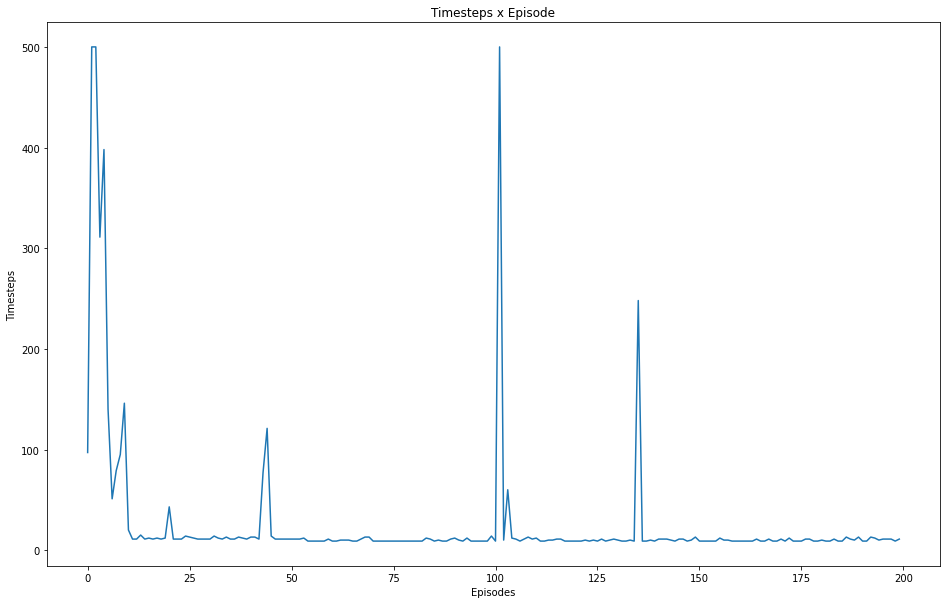

In [12]:
(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

ax.plot(path_per_episode)
ax.set_title('Timesteps x Episode')
ax.set_ylabel('Timesteps')
ax.set_xlabel('Episodes')

# Conclusão

Após treinar o modelo, o melhor caminho encontrado conta com **8 passos**. Obs: o tamanho da lista `path` é 9 pois a posição inicial também está sendo registrada.